<a href="https://colab.research.google.com/github/kaya-atakan/smart-home/blob/master/Revised_Context4act.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !git init
!git config --global user.email "93atakankaya@gmail.com"

In [2]:
import sys
import pandas as pd
from itertools import cycle
import numpy as np
import datetime as dt
from sklearn import linear_model
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateFormatter, AutoDateLocator, date2num
from matplotlib.dates import DateFormatter
import collections
import matplotlib.dates as md

pd.options.mode.chained_assignment = None 
import seaborn as sns; sns.set()
import pickle
import random

from pandas.api.types import CategoricalDtype

# !cat '/content/drive/My Drive/DFKI/Context4Act/context4act.py'

from google.colab import drive
drive.mount('/content/drive/')



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


#Reading the csv file and changing the column names

pd.to_datetime is needed because it will then allow us to use its various methods

In [0]:
context4_data_JULY = '/content/drive/My Drive/DFKI/Context4Act/July_All_Update.csv.log'
context4_data_NOVEMBER = '/content/drive/My Drive/DFKI/Context4Act/November_All_Update.csv.log'


columns = ['Timestamp','Sensor_id', 'Sensor_measure']

df_JULY = pd.read_csv(context4_data_JULY, sep=';', encoding='latin-1',names=columns)
df_NOVEMBER = pd.read_csv(context4_data_NOVEMBER, sep=';', encoding='latin-1',names=columns)

df_JULY['Timestamp'] = pd.to_datetime(df_JULY['Timestamp'])
# df_JULY.to_pickle('/content/drive/My Drive/DFKI/Context4Act/df_JULY_big.pkl')

df_NOVEMBER['Timestamp'] = pd.to_datetime(df_NOVEMBER['Timestamp'])
# df_NOVEMBER.to_pickle('/content/drive/My Drive/DFKI/Context4Act/df_NOVEMBER_big.pkl')


# df_JULY = df_JULY.loc[0: 100000]
# df_NOVEMBER = df_NOVEMBER.loc[0: 150000]
len(df_JULY)
len(df_NOVEMBER)

1866785

#Read pickle objects and append your current directory

In [50]:
df_JULY = pd.read_pickle('/content/drive/My Drive/DFKI/Context4Act/df_JULY_big.pkl')

df_NOVEMBER = pd.read_pickle('/content/drive/My Drive/DFKI/Context4Act/df_NOVEMBER_big.pkl')

sys.path.append('/content/drive/My Drive/DFKI/Context4Act')




Reinitialized existing Git repository in /content/.git/


#General information

In [5]:
df_JULY.info()
print('--------')
df_NOVEMBER.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604289 entries, 0 to 604288
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Timestamp       604289 non-null  datetime64[ns]
 1   Sensor_id       604289 non-null  object        
 2   Sensor_measure  604289 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 13.8+ MB
--------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1866785 entries, 0 to 1866784
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   Timestamp       datetime64[ns]
 1   Sensor_id       object        
 2   Sensor_measure  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 42.7+ MB


##Replacing French words

Since the original data includes some French nouns. I have written a separate script which includes several functions for processing data to avoid my notebook being cluttered


In [0]:
# from context4act import *
import context4act

df_JULY = context4act.replace_french(df_JULY)
df_JULY['Timestamp_hour'] = pd.to_datetime(df_JULY['Timestamp']).dt.hour
df_JULY['Timestamp_weekdays'] = pd.to_datetime(df_JULY['Timestamp']).dt.day_name()

df_NOVEMBER = context4act.replace_french(df_NOVEMBER)
df_NOVEMBER['Timestamp_hour'] = pd.to_datetime(df_NOVEMBER['Timestamp']).dt.hour
df_NOVEMBER['Timestamp_weekdays'] = pd.to_datetime(df_NOVEMBER['Timestamp']).dt.day_name()

# df['Timestamp_month'] = pd.to_datetime(df['Timestamp']).dt.month
# df['Timestamp_year'] = pd.to_datetime(df['Timestamp']).dt.year

In [7]:
df_NOVEMBER.head()

,Timestamp,Sensor_id,Sensor_measure,Timestamp_hour,Timestamp_weekdays
0,2016-11-14 17:45:38.704,R7_Mode_base,1,17,Monday
1,2016-11-14 17:45:38.782,Eau_Froide_Douche_Instantanee,0.0,17,Monday
2,2016-11-14 17:45:38.876,Energie_Partielle_Lave_Linge,424,17,Monday
3,2016-11-14 17:45:38.969,Color_1,"0.0,0.0,0.0",17,Monday
4,2016-11-14 17:45:38.985,CT_Dimm_1,0,17,Monday


##Current Activities during High/Low Energy Consumption 

In [0]:
def current_activity_function(data_frame):
  
  ''' This function outputs the activities the user 
  has engaged during 19:00 - 6:00 (high energy consumption) and 
  NOT(19:00 - 6:00, i.e., low energy consumption) for JULY and 
  7:00 - 16:00 (low) and 16:00 - 2:00 (high) for NOVEMBER'''

  current_activities_df = data_frame[data_frame['Sensor_id'] == 'current_activity']
  
  current_activities_df.set_index(pd.DatetimeIndex(current_activities_df.Timestamp),inplace=True)

  # if data_frame.equals(df_JULY):
  if data_frame is df_JULY:

#Get the number of activities when the total energy consumption is comparatively low
    current_acts_19_6 = current_activities_df.between_time('19:00', '6:00').Sensor_measure.value_counts()\
    .to_frame(name='Low energy activities')
  
    current_acts_19_6= current_acts_19_6[current_acts_19_6.index.str.contains("Start")]

#Get the number of activities when the total energy consumption is relatively high
    current_acts_not_19_6 = current_activities_df.between_time('6:00', '19:00').Sensor_measure.value_counts() \
    .to_frame(name='High energy activities')
    current_acts_not_19_6= current_acts_not_19_6[current_acts_not_19_6.index.str.contains("Start")]

    return [current_acts_19_6, current_acts_not_19_6] #returns a list of dataframes

  elif data_frame is df_NOVEMBER:

    #Energy Activities During 00:00 - 5:00
    current_acts_00_5 = current_activities_df.between_time('0:00', '5:00').Sensor_measure.value_counts()\
    .to_frame(name='Energy activities 00:00-05:00')
  
    current_acts_00_5 = current_acts_00_5[current_acts_00_5.index.str.contains("Start")]
    
    #High Energy Activities
    current_acts_7_16 = current_activities_df.between_time('7:00', '16:00').Sensor_measure.value_counts()\
    .to_frame(name='Energy activities 7-16')
  
    current_acts_7_16 = current_acts_7_16[current_acts_7_16.index.str.contains("Start")]
    
    #Low Energy Activities
    current_acts_16_2 = current_activities_df.between_time('16:00', '2:00').Sensor_measure.value_counts() \
    .to_frame(name='Energy activities 16-2')
    current_acts_16_2= current_acts_16_2[current_acts_16_2.index.str.contains("Start")]

    return [current_acts_00_5, current_acts_16_2, current_acts_7_16] #returns a list of dataframes



current_activity_lst_df_JULY = current_activity_function(df_JULY)
current_activity_lst_df_JULY
current_acts_19_6_JULY, current_acts_not_19_6_JULY = current_activity_lst_df_JULY[0], current_activity_lst_df_JULY[1]

current_activity_lst_NOVEMBER = current_activity_function(df_NOVEMBER)

current_acts_00_5_NOVEMBER = current_activity_lst_NOVEMBER[0]
current_acts_7_16_NOVEMBER = current_activity_lst_NOVEMBER[2]
current_acts_16_2_NOVEMBER = current_activity_lst_NOVEMBER[1]


Below you could also write couple of lines to extract activities between time periods rather than modifying the current_activity function

In [11]:
current_activities_df = df_NOVEMBER[df_NOVEMBER['Sensor_id'] == 'current_activity']

current_activities_df.set_index(pd.DatetimeIndex(current_activities_df.Timestamp),inplace=True)


current_acts_6_10 = current_activities_df.between_time('6:00', '10:00').Sensor_measure.value_counts() \
    .to_frame(name='High energy activities')
current_acts_6_10= current_acts_6_10[current_acts_6_10.index.str.contains("Start")]
current_acts_6_10

,High energy activities
Going_out_Start,21
Cuisine_Start,21
Dishes_Start,20
Manger_Start,16
Toilettes_Start,12
Douche_Start,10


## Make the days of the week start from Monday

ordering_weekdays function allows me to have the ordering between days. 

It comes really handy when you plot days. 
Without this function, you won't have the natural ordering (Monday preceding Tuesday, for example)

In [0]:
# energy_df_JULY_per_day_wout.reset_index()

def ordering_weekdays(dataframe):

  days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
  cat_type = CategoricalDtype(categories=days_of_week, ordered=True)

  # dataframe = dataframe[:-1] #Remove the column total
  # dataframe['Timestamp_weekdays'] = pd.to_datetime(dataframe['Timestamp']).dt.day_name()

  dataframe['Timestamp_weekdays'] = dataframe['Timestamp_weekdays'].astype(cat_type)

  return dataframe

# energy_df_JULY_weekday = ordering_weekdays(energy_df_JULY_per_day)

# energy_df_NOVEMBER_weekday = ordering_weekdays(energy_df_NOVEMBER_per_day)


## Total Energy Consumption

In [0]:
def weekday_within_day(dataframe, resampling, column_total = False, set_index = True):
  """ This function outputs Row Total depending on each
      weekday by varying resampling frequency, which will be used in a plot later. """
  
  frames = []
  days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
  cat_type = CategoricalDtype(categories=days_of_week, ordered=True)  

  partielle_lst = dataframe[dataframe['Sensor_id'].str.contains("Energie_Partielle")].Sensor_id.unique().tolist()
  
  for partielle in partielle_lst:

    # total_energy_partielle = dataframe[dataframe['Sensor_id'] == partielle] \
    # .groupby(by=[pd.to_datetime(dataframe['Timestamp']).dt.hour, 'Timestamp_weekdays']) \
    # .apply(context4act.first_last) \
    # .to_frame(name=partielle).reset_index()

    total_energy_partielle_five = dataframe[dataframe['Sensor_id'] == partielle] \
    .groupby(by=pd.Grouper(key='Timestamp', freq=resampling)) \
    .apply(context4act.first_last) \
    .to_frame(name=partielle).reset_index()

    frames.append(total_energy_partielle_five)
  
  concatenated_frames = pd.concat(frames, axis=1)
  concatenated_frames = concatenated_frames.loc[:,~concatenated_frames.columns.duplicated()]
  
  concatenated_frames.loc[:,'Row_Total'] = concatenated_frames.sum(numeric_only=True, axis=1)

  concatenated_frames['Timestamp_weekdays'] = pd.to_datetime(concatenated_frames['Timestamp']).dt.day_name()
  concatenated_frames['Timestamp_weekdays'] = concatenated_frames['Timestamp_weekdays'].astype(cat_type)
  
  concatenated_frames.sort_values(['Timestamp_weekdays', 'Timestamp'])
  concatenated_frames['Hours'] = concatenated_frames.Timestamp.dt.hour

  if set_index == True:
    concatenated_frames.set_index('Timestamp', inplace=True)
    concatenated_frames.dropna(inplace=True) #Drop any NaN or NaT value
    
    if column_total == False:
      return concatenated_frames
    
    elif not column_total == False:
      concatenated_frames.loc['Column_Total']= concatenated_frames.sum(numeric_only=True, axis=0)

      return concatenated_frames

  elif set_index == False:
    concatenated_frames.dropna(inplace=True) #Drop any NaN or NaT value
    
    if column_total == False:
      return concatenated_frames
    
    elif not column_total == False:
      concatenated_frames.loc['Column_Total']= concatenated_frames.sum(numeric_only=True, axis=0)

      return concatenated_frames

 

within_day_5min_JULY = weekday_within_day(df_JULY, '5min', column_total=False, set_index=True)
within_day_5min_NOVEMBER = weekday_within_day(df_NOVEMBER, '5min',column_total=False, set_index=True)

within_day_hour_JULY = weekday_within_day(df_JULY, '1H',column_total=False, set_index= True)
within_day_hour_NOVEMBER = weekday_within_day(df_NOVEMBER, '1H',column_total=False, set_index = True)




#Adding Weekend Feature 
This cell allows me to create Weekend column so that I can compare weekdays and weekends in order to see how much they deviate from each other w.t.r. energy consumption.

In [0]:
within_day_5min_JULY['Weekend_Friday'] = ((pd.DatetimeIndex(within_day_5min_JULY.index).dayofweek) // 4 == 1).astype(float)

Friday_without_5min_JULY = within_day_5min_JULY.loc[(within_day_5min_JULY['Weekend_Friday'] == 1) & ~(within_day_5min_JULY.Timestamp_weekdays == 'Friday')]
Friday_5min_JULY = within_day_5min_JULY.loc[(within_day_5min_JULY['Weekend_Friday'] == 1) & (within_day_5min_JULY.Timestamp_weekdays == 'Friday')]


within_day_5min_NOVEMBER['Weekend_Friday'] = ((pd.DatetimeIndex(within_day_5min_NOVEMBER.index).dayofweek) // 4 == 1).astype(float)

Friday_without_5min_NOVEMBER = within_day_5min_NOVEMBER.loc[(within_day_5min_NOVEMBER['Weekend_Friday'] == 1) & ~(within_day_5min_NOVEMBER.Timestamp_weekdays == 'Friday')]
Friday_5min_NOVEMBER = within_day_5min_NOVEMBER.loc[(within_day_5min_NOVEMBER['Weekend_Friday'] == 1) & (within_day_5min_NOVEMBER.Timestamp_weekdays == 'Friday')]

business_NOVEMBER = within_day_5min_NOVEMBER[within_day_5min_NOVEMBER['Weekend_Friday'] == 0]



In [32]:
# Friday_without_5min_NOVEMBER.Timestamp_weekdays.unique().tolist()
within_day_5min_NOVEMBER.Timestamp_weekdays.unique().tolist()

['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

##The number of times Fridge Door opened each day

In [33]:
fridge_door_per_day_JULY = context4act.fridge_door_opening_times(df_JULY)
fridge_door_per_day_NOVEMBER = context4act.fridge_door_opening_times(df_NOVEMBER)

print(fridge_door_per_day_JULY)
print('-----')
print(fridge_door_per_day_NOVEMBER)

            Door OPEN
Timestamp            
2016-07-25        5.0
2016-07-26       21.0
2016-07-27       13.0
2016-07-28       26.0
2016-07-29       26.0
2016-07-30       17.0
2016-07-31       24.0
2016-08-01        0.0
-----
            Door OPEN
Timestamp            
2016-11-14        4.0
2016-11-15        7.0
2016-11-16       13.0
2016-11-17       19.0
2016-11-18       14.0
2016-11-19       15.0
2016-11-20       22.0
2016-11-21       17.0
2016-11-22       14.0
2016-11-23        7.0
2016-11-24       13.0
2016-11-25       17.0
2016-11-26       16.0
2016-11-27       17.0
2016-11-28       10.0
2016-11-29       15.0
2016-11-30       18.0
2016-12-01       15.0
2016-12-02       11.0
2016-12-03       19.0
2016-12-04       10.0
2016-12-05        4.0


## Fridge Energy Consumption for July/November per Day

In [34]:
fridge_energy_JULY = df_JULY[df_JULY['Sensor_id'] == 'Energie_Partielle_Frigo'].groupby(by=pd.to_datetime(df_JULY['Timestamp']).dt.date).apply(context4act.first_last)
fridge_energy_JULY = fridge_energy_JULY.to_frame(name='Fridge Energy Consumption per Day')

FRIDGE_ENERGY_NOVEMBER = df_NOVEMBER[df_NOVEMBER['Sensor_id'] == 'Energie_Partielle_Frigo'].groupby(by=pd.to_datetime(df_NOVEMBER['Timestamp']).dt.date).apply(context4act.first_last)

FRIDGE_ENERGY_NOVEMBER = FRIDGE_ENERGY_NOVEMBER.to_frame(name='Fridge Energy Consumption per Day')

print(fridge_energy_JULY['Fridge Energy Consumption per Day'])
print('-------')
print(FRIDGE_ENERGY_NOVEMBER['Fridge Energy Consumption per Day'])

Timestamp
2016-07-25    216.0
2016-07-26    554.0
2016-07-27    770.0
2016-07-28    548.0
2016-07-29    513.0
2016-07-30    504.0
2016-07-31    531.0
2016-08-01    171.0
Name: Fridge Energy Consumption per Day, dtype: float64
-------
Timestamp
2016-11-14     76.0
2016-11-15    276.0
2016-11-16    290.0
2016-11-17    302.0
2016-11-18    348.0
2016-11-19    315.0
2016-11-20    316.0
2016-11-21    348.0
2016-11-22    366.0
2016-11-23    324.0
2016-11-24    303.0
2016-11-25    334.0
2016-11-26    356.0
2016-11-27    299.0
2016-11-28    283.0
2016-11-29    295.0
2016-11-30    294.0
2016-12-01    275.0
2016-12-02    289.0
2016-12-03    270.0
2016-12-04    264.0
2016-12-05    196.0
Name: Fridge Energy Consumption per Day, dtype: float64


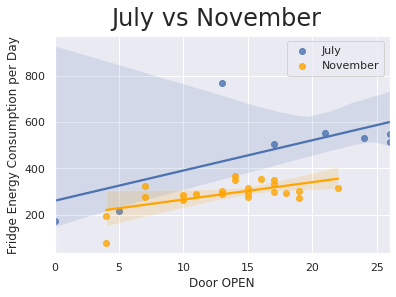

In [35]:
fig = sns.regplot(x=fridge_door_per_day_JULY['Door OPEN'], y=fridge_energy_JULY['Fridge Energy Consumption per Day'], 
                  color='b', label='July')
fig = sns.regplot(x=fridge_door_per_day_NOVEMBER['Door OPEN'], y=FRIDGE_ENERGY_NOVEMBER['Fridge Energy Consumption per Day'],
                  color='orange', label='November')

fig.figure.suptitle("July vs November", fontsize = 24)

# new_title = 'July vs November'
# fig.set_title(new_title)

fig.legend()

# July vs November Energy Consumption on an hourly basis

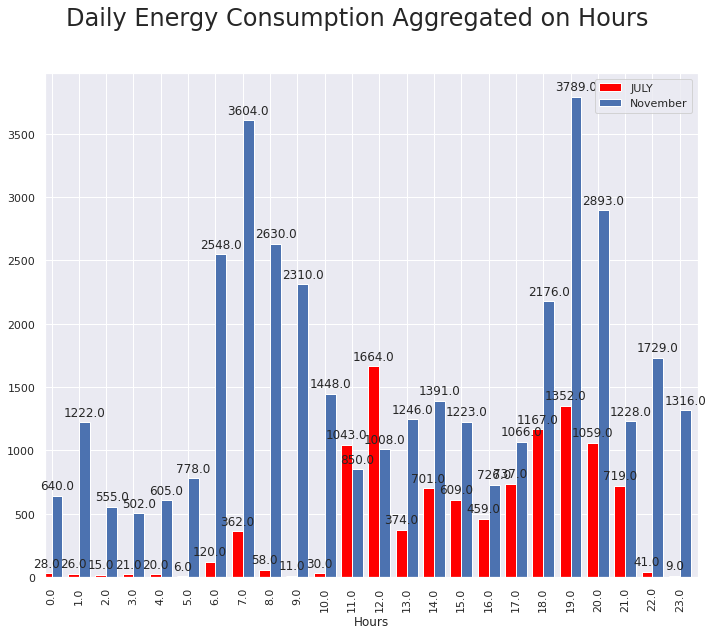

<Figure size 432x288 with 0 Axes>

In [36]:
a4_dims = (11.7, 9.27) #Configure the plot size
fig, ax = plt.subplots(figsize=a4_dims)
# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']


within_day_5min_JULY.groupby('Hours')['Row_Total'].sum() \
.reset_index() \
.plot.bar('Hours', 'Row_Total', ax=ax, label='JULY', color='red', position=1, width=0.4 )


within_day_5min_NOVEMBER.groupby('Hours')['Row_Total'].sum() \
.reset_index() \
.plot.bar('Hours', 'Row_Total', ax=ax, label='November', position=0, width=0.4)

# for p in ax.patches[0:]:
#     plt.gca().text(p.get_x() + p.get_width()/2, p.get_height()+0.01, str(float(p.get_height())), 
#                  ha='center', va='baseline', rotation=0 ,color='black', fontsize=25)


for p in ax.patches: 
  ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# plt.title("E")
# plt.legend(title="Network")
# fig.legend(new_labels)
fig.suptitle("Daily Energy Consumption Aggregated on Hours ", fontsize = 24)
plt.show()
plt.tight_layout()



This plot and **Weekend Plot** below shows clearly that the energy consumption patterns of weekdays and weekends differ significantly from one another.


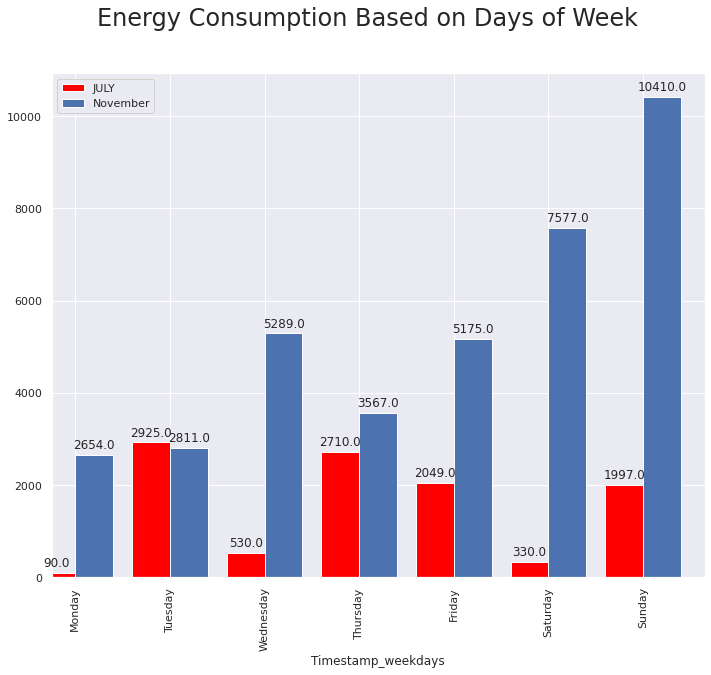

<Figure size 432x288 with 0 Axes>

In [37]:
a4_dims = (11.7, 9.27) #Configure the plot size
fig, ax = plt.subplots(figsize=a4_dims)
# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']


within_day_5min_JULY.groupby('Timestamp_weekdays')['Row_Total'].sum() \
.reset_index() \
.plot.bar('Timestamp_weekdays', 'Row_Total', ax=ax, label='JULY', color='red', position=1, width=0.4 )


within_day_5min_NOVEMBER.groupby('Timestamp_weekdays')['Row_Total'].sum() \
.reset_index() \
.plot.bar('Timestamp_weekdays', 'Row_Total', ax=ax, label='November', position=0, width=0.4)

# for p in ax.patches[0:]:
#     plt.gca().text(p.get_x() + p.get_width()/2, p.get_height()+0.01, str(float(p.get_height())), 
#                  ha='center', va='baseline', rotation=0 ,color='black', fontsize=25)


for p in ax.patches: 
  ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# plt.title("E")
# plt.legend(title="Network")
# fig.legend(new_labels)
fig.suptitle("Energy Consumption Based on Days of Week", fontsize = 24)
plt.show()
plt.tight_layout()



## November plot on an hour basis

I just wanted to plot November data alone in order to see clearly the patterns.

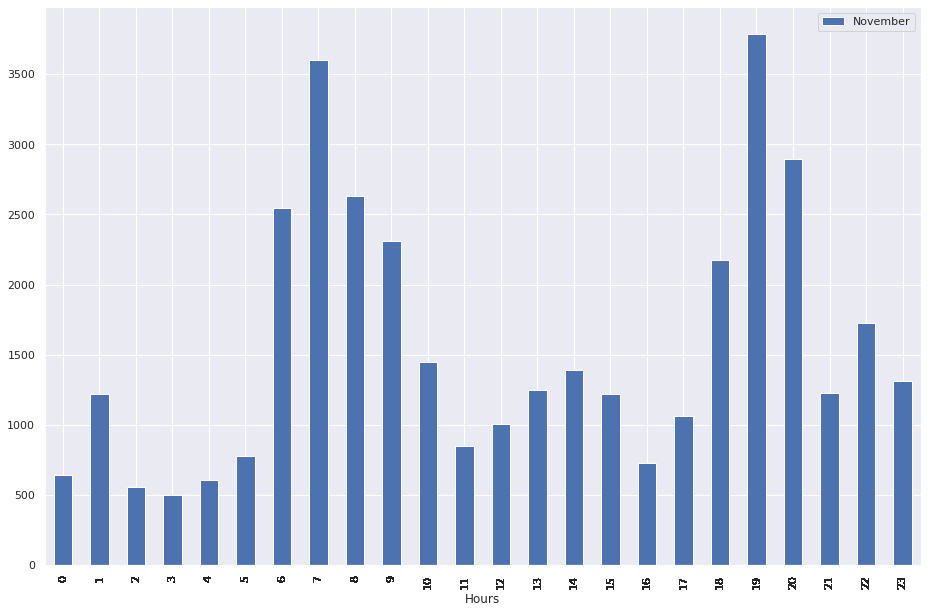

In [38]:
a4_dims = (15.7, 10.27) #Configure the plot size
fig, ax = plt.subplots(figsize=a4_dims)
within_day_5min_NOVEMBER.groupby(within_day_5min_NOVEMBER.Hours)['Row_Total'].sum() \
.reset_index() \
.plot('Hours', 'Row_Total', ax=ax, label='November', xticks = within_day_5min_NOVEMBER.Hours, kind='bar') #Avoid NaN

# ax.set(xticks=within_day_5min_NOVEMBER.Timestamp.dt.hour) # This sets all the hours




#Weekend Plots

This plot and the one after  show us how much the user actually acts differently on weekend days and engages in a different routine. For example, the user wakes up relatively late on weekend days compared to Fridays. 

Plus, it should be noted that the overall energy consumption on weekend days (Sat and Sun) is relatively higher than Fridays (see the latter plot), meaning that the user spends much of his/her time at home.

## Business days vs Weekend (excluding Friday)

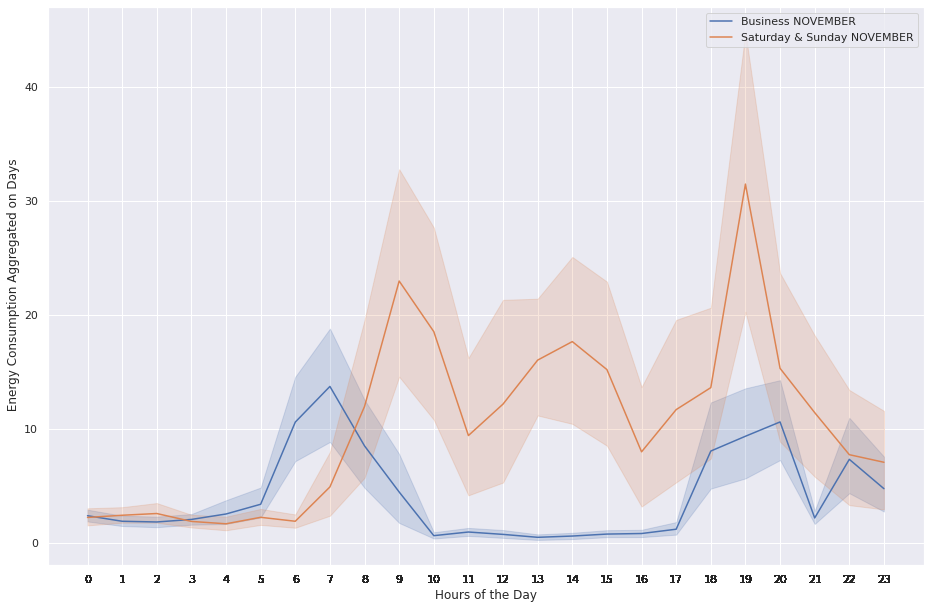

In [39]:
a4_dims = (15.7, 10.27) #Configure the plot size
fig, ax = plt.subplots(figsize=a4_dims)

sns.lineplot(ax =ax,  x=business_NOVEMBER.Hours, y=business_NOVEMBER['Row_Total'], label= 'Business NOVEMBER')
sns.lineplot(ax =ax,  x=Friday_without_5min_NOVEMBER.Hours, y=Friday_without_5min_NOVEMBER['Row_Total'],  label='Saturday & Sunday NOVEMBER')

# sns.lineplot(ax =ax,  x=Friday_5min_JULY.Hours, y=Friday_5min_JULY['Row_Total'], label= 'Friday JULY')
# sns.lineplot(ax =ax,  x=Friday_without_5min_JULY.Hours, y=Friday_without_5min_JULY['Row_Total'],  label='Saturday & Sunday JULY')

ax.set(xticks=business_NOVEMBER.Hours) # This sets all the hours
ax.set(xlabel='Hours of the Day', ylabel=' Energy Consumption Aggregated on Days')

ax.legend()

## Friday vs Weekend

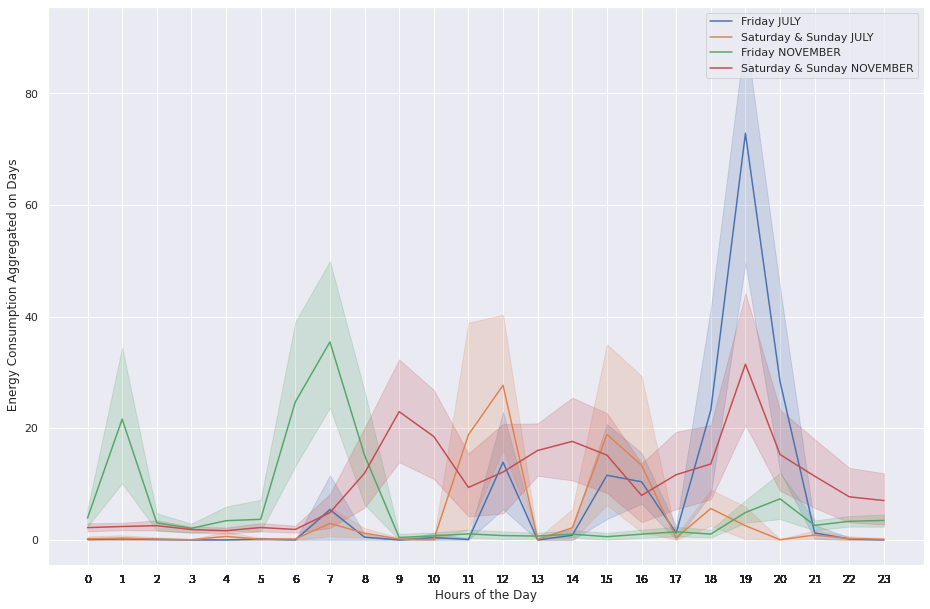

In [40]:
a4_dims = (15.7, 10.27) #Configure the plot size
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(ax =ax,  x=Friday_5min_JULY.Hours, y=Friday_5min_JULY['Row_Total'], label= 'Friday JULY')
sns.lineplot(ax =ax,  x=Friday_without_5min_JULY.Hours, y=Friday_without_5min_JULY['Row_Total'],  label='Saturday & Sunday JULY')

# ax.set(xticks=energy_df_JULY_per_hour_wout.Timestamp.values.astype(float)) # This sets all the hours

sns.lineplot(ax =ax,  x=Friday_5min_NOVEMBER.Hours, y=Friday_5min_NOVEMBER['Row_Total'], label= 'Friday NOVEMBER')
sns.lineplot(ax =ax,  x=Friday_without_5min_NOVEMBER.Hours, y=Friday_without_5min_NOVEMBER['Row_Total'],  label='Saturday & Sunday NOVEMBER')

ax.set(xticks=Friday_5min_NOVEMBER.Hours) # This sets all the hours
ax.set(xlabel='Hours of the Day', ylabel=' Energy Consumption Aggregated on Days')

ax.legend()

# reg_energy_sleep.figure.suptitle("July Energy Consumption Based on Days of Week", fontsize = 24)
# new_labels = ['Friday JULY', 'Saturday & Sunday JULY']

# fig.legend(new_labels)

In [41]:
within_day_5min_NOVEMBER.groupby(within_day_5min_NOVEMBER.Hours)['Row_Total'].sum()

Hours
0.0      640.0
1.0     1222.0
2.0      555.0
3.0      502.0
4.0      605.0
5.0      778.0
6.0     2548.0
7.0     3604.0
8.0     2630.0
9.0     2310.0
10.0    1448.0
11.0     850.0
12.0    1008.0
13.0    1246.0
14.0    1391.0
15.0    1223.0
16.0     726.0
17.0    1066.0
18.0    2176.0
19.0    3789.0
20.0    2893.0
21.0    1228.0
22.0    1729.0
23.0    1316.0
Name: Row_Total, dtype: float64

## November plot on an hour basis

I just wanted to plot November data alone in order to see clearly the patterns.

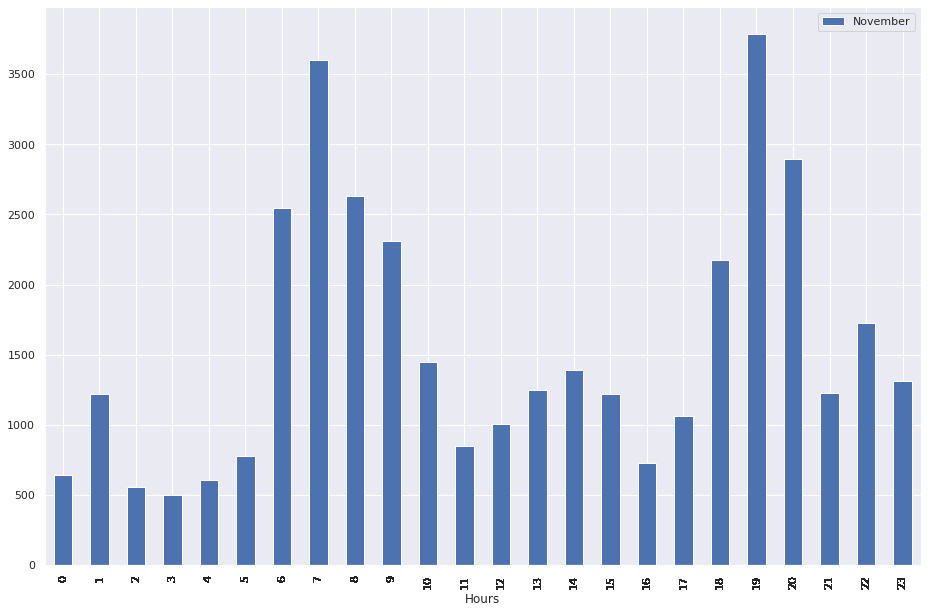

In [42]:
a4_dims = (15.7, 10.27) #Configure the plot size
fig, ax = plt.subplots(figsize=a4_dims)
within_day_5min_NOVEMBER.groupby(within_day_5min_NOVEMBER.Hours)['Row_Total'].sum() \
.reset_index() \
.plot('Hours', 'Row_Total', ax=ax, label='November', xticks = within_day_5min_NOVEMBER.Hours, kind='bar') #Avoid NaN

# ax.set(xticks=within_day_5min_NOVEMBER.Timestamp.dt.hour) # This sets all the hours




## All day plot November

This might be the nicest plot among the others probably because it shows energy consumption across all the days aggregated on hours in November data. Therefore, you can selectively attend to the peaks to make comparisons within and between days.

For example, if you look at **Sundays**, you would immediately realize that they are quite different in some obvious ways, w.r.t. the other days. To, illustrate, if you take a peek at morning hours, you would notice that the user wakes up relatively late as compared to other days.

Additionally, you would see that Sundays and Saturdays seem to be consistent with each other.

Working days also seem be consistent such that there are huge peaks at some specific hours, namely, the hours at which the user wakes up to go to work and the hours at which the user comes home and engage in several activities. In the next cell, I extracted user activities happening between 18:00 - 20:00 and between 6:00 - 8:00.

Further, it seems that we can also detect presence of the user at home. So, if you look at Tuesday and Wednesday on the first row of plots, you would see that we don't see the usual peaks between 18:00 - 20:00 on Tuesday neither we see them between 6:00 - 8:00 next day morning on Wednesday.

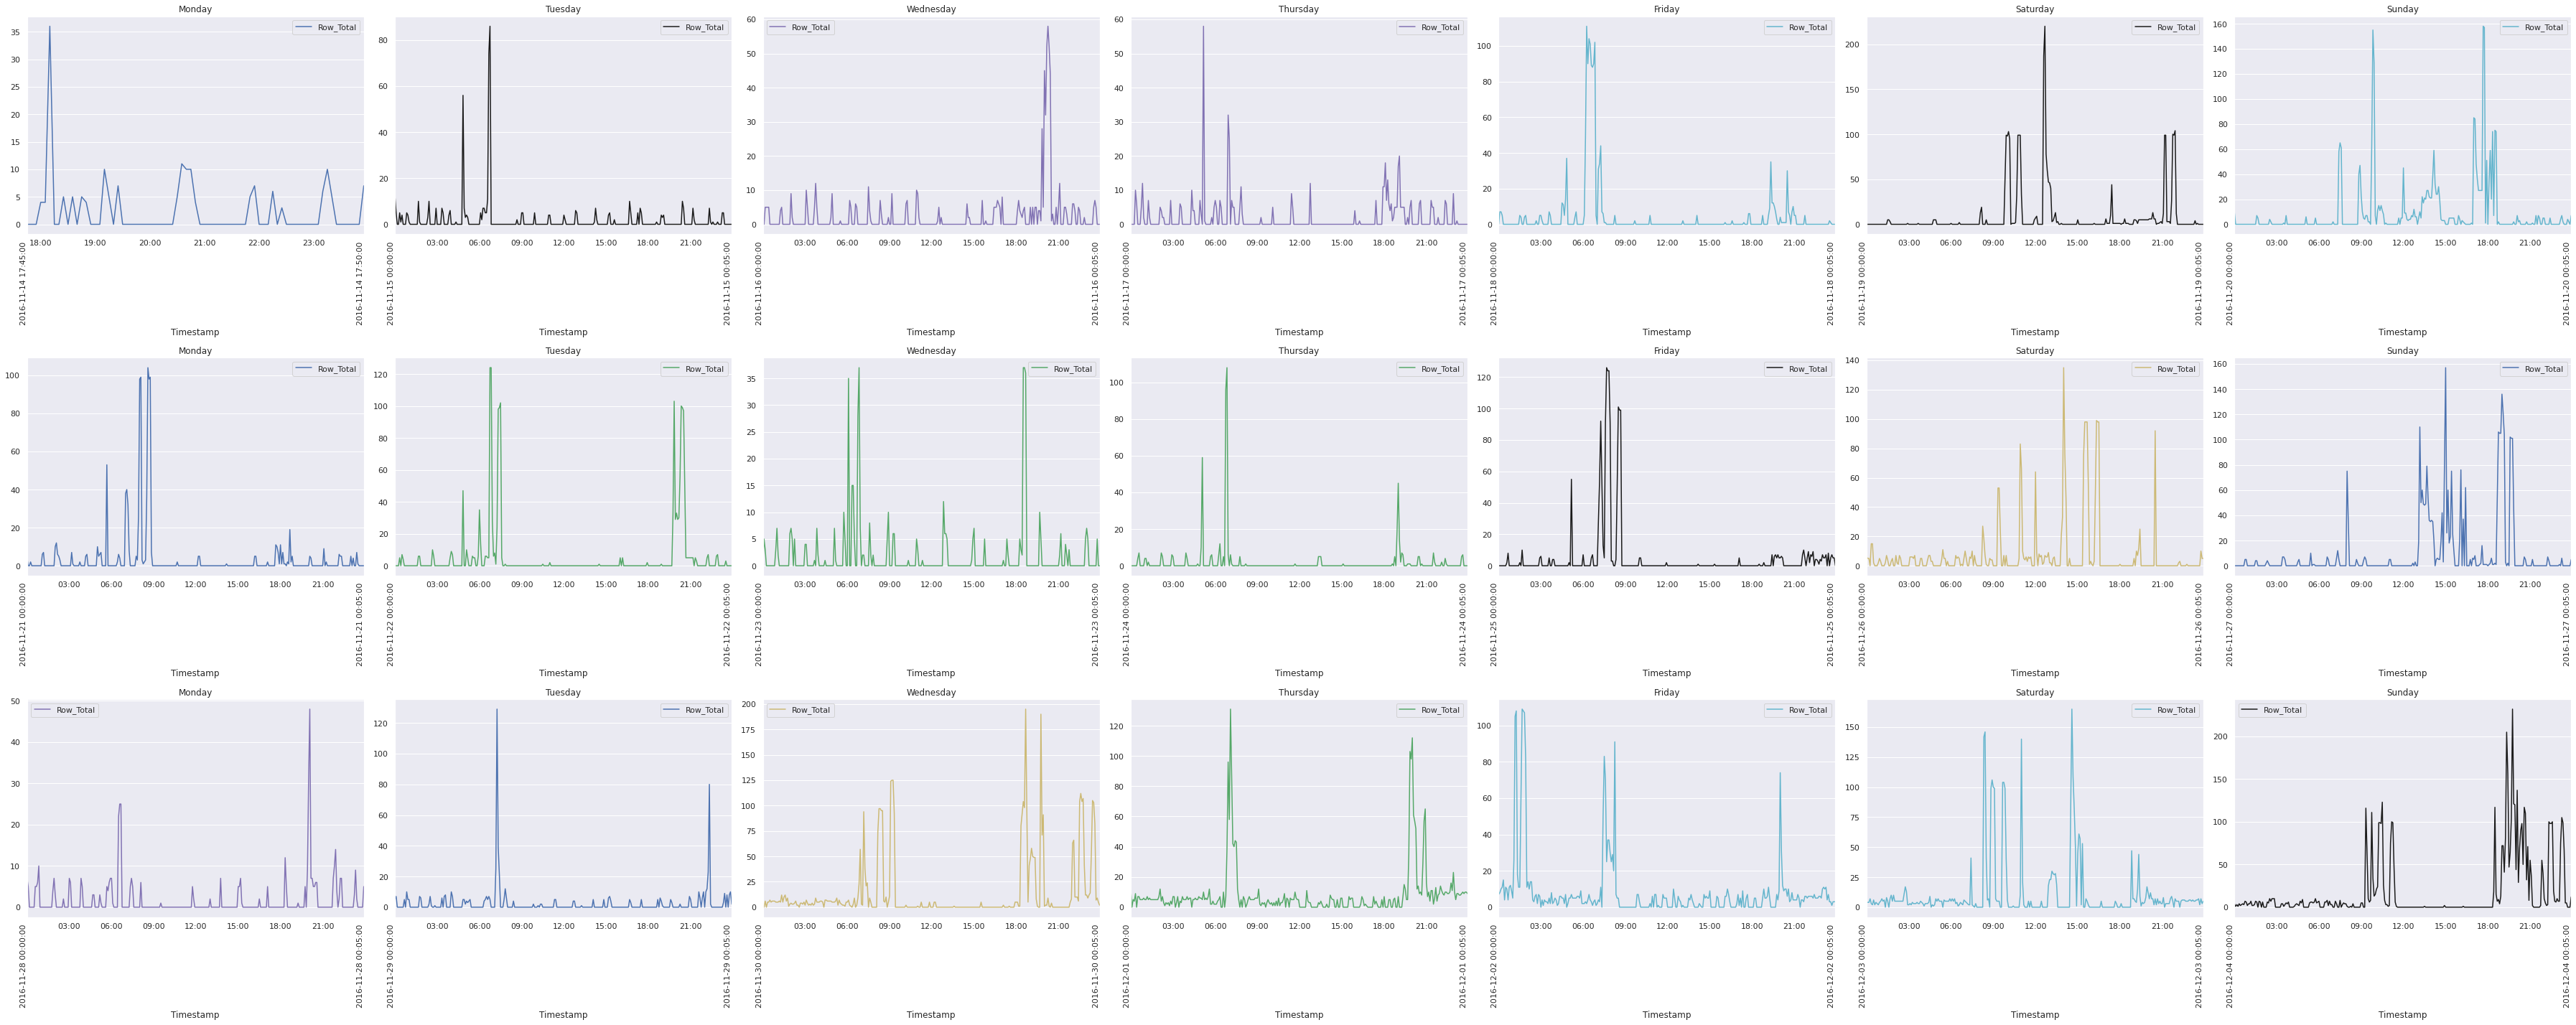

In [43]:
# %cd drive/My\ Drive
# %cd DFKI/Context4Act/
# %mkdir plots_Context4Act
def plot_interval_on_weekdays_NOVEMBER(dataframe):
  
  unique_dates_NOVEMBER = within_day_5min_NOVEMBER.reset_index().Timestamp.dt.strftime('%Y-%m-%d').unique().tolist()

  colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

  if dataframe is within_day_5min_NOVEMBER:
    days_NOVEMBER = []
    days_lst_NOVEMBER = list(zip(unique_dates_NOVEMBER, pd.to_datetime(unique_dates_NOVEMBER).weekday)) 

    for date in unique_dates_NOVEMBER[:-1]: #Remove the first monday to ensure the consistency among days
      days_NOVEMBER.append(within_day_5min_NOVEMBER.loc[date]) # appends df's to the empty list
      
      # days_NOVEMBER = days_NOVEMBER[1:] #Remove the first monday to ensure the consistency among days
    
    fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(50,20))
    for i, ax in enumerate(axes.flatten()):

      days_NOVEMBER[i].reset_index().plot('Timestamp', 'Row_Total',  legend=True, 
                                          ax = ax, title = (pd.to_datetime(days_lst_NOVEMBER[i][0]).day_name()), 
                                          color=random.choice(colors))

      ax.set_xticklabels(labels=days_NOVEMBER[i].reset_index().Timestamp, rotation=90, ha='right')
      ax.set_xlim(days_NOVEMBER[i].index[0], days_NOVEMBER[i].index[-1])

  return plt.tight_layout() 
  # return plt.savefig(plot1.png)


(plot_interval_on_weekdays_NOVEMBER(within_day_5min_NOVEMBER))
# plt.savefig('within_day_5min_NOVEMBER.png')


I took display_side_by_side function from the following link:

https://stackoverflow.com/a/57832026/10049728

Here, you can see that the user seems to take a shower in the morning, probably before going to work.

In [44]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))


current_activities_df_NOVEMBER = df_NOVEMBER[df_NOVEMBER['Sensor_id'] == 'current_activity']

current_activities_df_NOVEMBER.set_index(pd.DatetimeIndex(current_activities_df_NOVEMBER.Timestamp),inplace=True)

# display(current_acts_18_20_NOVEMBER)

#Current Activities 18:00 - 20:00
current_acts_18_20_NOVEMBER = current_activities_df_NOVEMBER.between_time('18:00', '20:00').Sensor_measure.value_counts() \
    .to_frame(name='High energy activities')
current_acts_18_20_NOVEMBER= current_acts_18_20_NOVEMBER[current_acts_18_20_NOVEMBER.index.str.contains("Start")]

# display(current_acts_6_8_NOVEMBER)
current_acts_6_8_NOVEMBER = current_activities_df_NOVEMBER.between_time('6:00', '8:00').Sensor_measure.value_counts() \
    .to_frame(name='High energy activities')
current_acts_6_8_NOVEMBER= current_acts_6_8_NOVEMBER[current_acts_6_8_NOVEMBER.index.str.contains("Start")]

#Current Activities 18:00 - 19:00
current_acts_18_19_NOVEMBER = current_activities_df_NOVEMBER.between_time('18:00', '19:00').Sensor_measure.value_counts() \
    .to_frame(name='High energy activities')
current_acts_18_19_NOVEMBER= current_acts_18_19_NOVEMBER[current_acts_18_19_NOVEMBER.index.str.contains("Start")]

#Current Activities 6:00 - 7:00
current_acts_6_7_NOVEMBER = current_activities_df_NOVEMBER.between_time('6:00', '7:00').Sensor_measure.value_counts() \
    .to_frame(name='High energy activities')
current_acts_6_7_NOVEMBER= current_acts_6_7_NOVEMBER[current_acts_6_7_NOVEMBER.index.str.contains("Start")]


display_side_by_side([current_acts_18_19_NOVEMBER, current_acts_18_20_NOVEMBER, current_acts_6_7_NOVEMBER, current_acts_6_8_NOVEMBER], ['18:00 - 19:00', '18:00 - 20:00', '6:00 - 7:00', '6:00 - 8:00 '])

,High energy activities
Toilettes_Start,6
Cuisine_Start,5
Dishes_Start,2
Manger_Start,1
Work_Start,1
,High energy activities
Toilettes_Start,13
Cuisine_Start,12
Manger_Start,7
Dishes_Start,6


<br>
<br>
<br>

Below, the first element of tuples refers to the time and the second element shows us how many times the user started an activity. Now, we understand why we have those peaks...  



In [45]:
from collections import Counter
sorted(Counter(current_activities_df_NOVEMBER.Timestamp_hour.to_list()).most_common(4))

[(6, 67), (7, 93), (18, 39), (19, 50)]

#All day plot July

Remember that the user worked home office in July. Plus, we have only data for 8 days

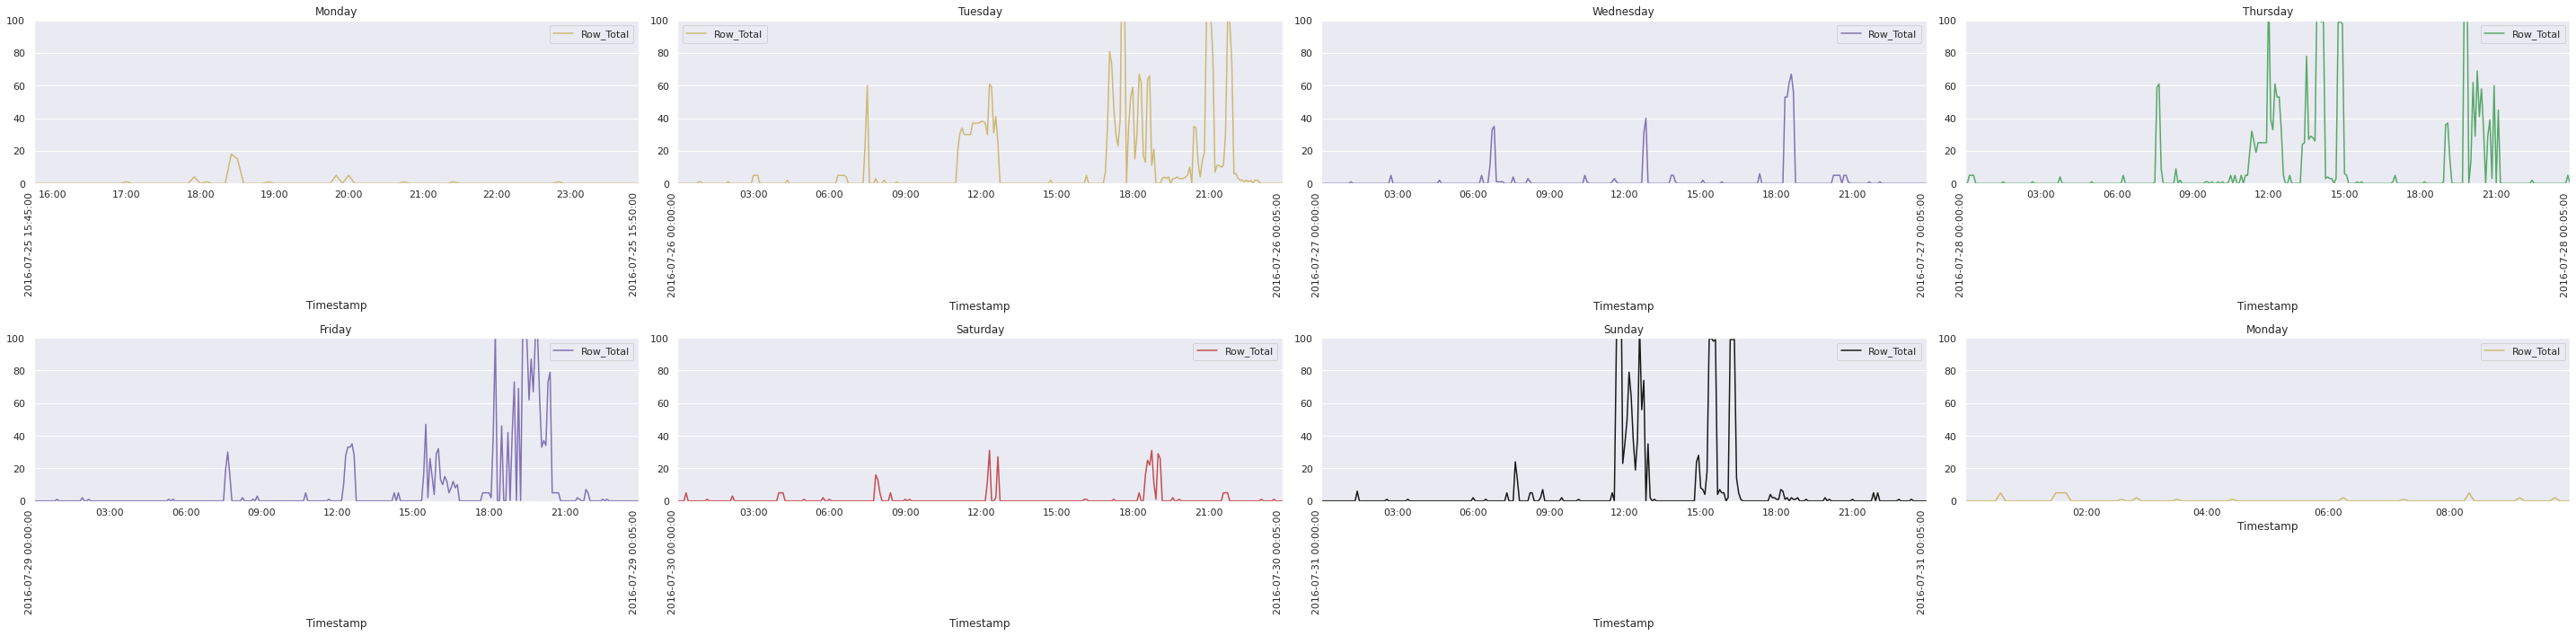

In [46]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name


def plot_interval_on_weekdays_JULY(dataframe):

  colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

  if dataframe is within_day_5min_JULY:
    unique_dates_JULY = within_day_5min_JULY.reset_index().Timestamp.dt.strftime('%Y-%m-%d').unique().tolist()

    # days_JULY = [Monday_1, Monday_2, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday]
    days_JULY = []
    days_lst_JULY = list(zip(unique_dates_JULY, pd.to_datetime(unique_dates_JULY).weekday))

    for date in (unique_dates_JULY):
      days_JULY.append(within_day_5min_JULY.loc[date])
    # for indx in pd.to_datetime(unique_dates_JULY).weekday.tolist():
    #   days_JULY.append(dataframe[dataframe.index.weekday == indx])
  
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40,10))
    for i, ax in enumerate(axes.flatten()):
      # print(i)

    # plt.gca().xaxis_date.set_major_formatter(DateFormatter('%H:%M:%S'))
      days_JULY[i].reset_index().plot('Timestamp', 'Row_Total',  legend=True, ax = ax, title= (pd.to_datetime(days_lst_JULY[i][0]).day_name()),color=random.choice(colors))

      ax.set_xticklabels(labels=days_JULY[i].reset_index().Timestamp, rotation=90, ha='right')
      ax.set_xlim(days_JULY[i].index[0], days_JULY[i].index[-1])
      ax.set_ylim([0,100])


      plt.gca().xaxis.set_major_locator(md.HourLocator(interval=1))

      # ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
  return  plt.tight_layout() #This avoid the ovrlapping of x-axis labels

plot_interval_on_weekdays_JULY(within_day_5min_JULY)
# plt.savefig('within_day_5min_JULY.png')


In [47]:
# a4_dims = (15.7, 12.27) #Configure the plot size
# fig, ax = plt.subplots(figsize=a4_dims)
Monday_1 = within_day_5min_JULY.loc['2016-07-25'] # We have two mondays
Monday_2 = within_day_5min_JULY.loc['2016-08-01'] # We have two mondays

Tuesday = within_day_5min_JULY[within_day_5min_JULY.index.weekday==1]
Wednesday = within_day_5min_JULY[within_day_5min_JULY.index.weekday==2]
Thursday = within_day_5min_JULY[within_day_5min_JULY.index.weekday==3]
Friday = within_day_5min_JULY[within_day_5min_JULY.index.weekday==4]
for i in range(0, len(days)):
  days[i].reset_index().plot('Timestamp', 'Row_Total')

NameError: ignored

In [0]:
a4_dims = (11.7, 8.27) #Configure the plot size
fig, ax = plt.subplots(figsize=a4_dims)

reg_energy_sleep = sns.lineplot(ax =ax,  x=within_day_hour_NOVEMBER.Hours, y=within_day_hour_NOVEMBER['Row_Total'], hue=within_day_hour_NOVEMBER.Timestamp_weekdays)
# reg_energy_sleep = sns.catplot(x=wurzburg.Hours, y=wurzburg.Row_Total)
ax.set(xticks=within_day_hour_NOVEMBER.Hours) # This sets all the hours
ax.set(xlabel='Hours of the Day', ylabel='Total Energy Consumption Aggregated on Days')

reg_energy_sleep.figure.suptitle("November Energy Consumption Based on Days of Week", fontsize = 24)

In [0]:
a4_dims = (11.7, 8.27) #Configure the plot size
fig, ax = plt.subplots(figsize=a4_dims)

reg_energy_sleep = sns.lineplot(ax =ax,  x=within_day_hour_JULY.Hours, y=within_day_hour_JULY['Row_Total'])
# ax.set(xticks=within_day_hour_JULY.Hours)) # This sets all the hours
ax.set(xlabel='Hours of the Day', ylabel='Total Energy Consumption Aggregated on Days')
ax.set(xticks=within_day_hour_JULY.Hours.values.astype(float)) # This sets all the hours


# sub_axes = plt.axes([.175, .6, .25, .25]) 

# # plot the zoomed portion
# sub_axes.plot(within_day_hour_JULY.iloc[0:8]['Hours'], within_day_hour_JULY.iloc[0:8]['Row_Total'], c = 'k')

reg_energy_sleep.figure.suptitle("July Close-up Energy Consumption Based on Hours", fontsize = 24)


# MEAN PLOT
What this plot does is that it calculates the mean row total of the specific time periods. 
For instance, if you run the code below, you would see the mean value of
energy consumption precisely at 7.00 o'clock.


within_day_hour_NOVEMBER[within_day_hour_NOVEMBER.Hours == 7].mean()



In [0]:
a4_dims = (11.7, 8.27) #Configure the plot size
fig, ax = plt.subplots(figsize=a4_dims)

reg_energy_sleep = sns.lineplot(ax =ax,  x=within_day_hour_JULY.Hours, y=within_day_hour_JULY['Row_Total'])

reg_energy_sleep = sns.lineplot(ax =ax,  x=within_day_hour_NOVEMBER.Hours, y=within_day_hour_NOVEMBER['Row_Total'])
ax.set(xticks=within_day_hour_NOVEMBER.Hours.values.astype(float)) # This sets all the hours
ax.set(xlabel='Hours of the Day', ylabel='Total Energy Consumption Aggregated on Days')

reg_energy_sleep.figure.suptitle("July and November Mean Energy Consumption Plot ", fontsize = 24)
new_labels = ['July', 'November']
reg_energy_sleep.legend(new_labels)


# Activities Charts

## July Activities

In [0]:
a4_dims = (12.7, 6.27) #Configure the plot size
fig, ax = plt.subplots(figsize=a4_dims)
low_energy_plot_JULY = sns.barplot(ax =ax, x = current_acts_19_6_JULY.index, y =  current_acts_19_6_JULY['Low energy activities'] )
low_energy_plot_JULY.set(xlabel='Activities', ylabel='# of Activies done within 19:00 - 6:00')
# low_energy_plot.set(xlabel='Between 19:00 - 6:00', font_scale=3)

for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
_ = low_energy_plot_JULY.set_ylim(0,16)

low_energy_plot_JULY.figure.suptitle("July Activities Done Between 19:00 - 6:00 ", fontsize = 24)


In [0]:
a4_dims = (15.7, 8.27) #Configure the plot size
fig, ax = plt.subplots(figsize=a4_dims)
high_energy_plot_JULY = sns.barplot(ax =ax, x = current_acts_not_19_6_JULY.index, y =  current_acts_not_19_6_JULY['High energy activities'] )
high_energy_plot_JULY.set(xlabel='User Activities', ylabel='# of Activies done within 19:00 - 6:00')

for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
_ = high_energy_plot_JULY.set_ylim(0,40)


high_energy_plot_JULY.figure.suptitle("July Activities Done Between (6:00 - 19:00) ", fontsize = 24)


## November Activities

In [0]:
a4_dims = (12.7, 6.27) #Configure the plot size
fig, ax = plt.subplots(figsize=a4_dims)
low_energy_plot_NOVEMBER = sns.barplot(ax =ax, x = current_acts_7_16_NOVEMBER.index, y =   current_acts_7_16_NOVEMBER['Energy activities 7-16'] )
low_energy_plot_NOVEMBER.set(xlabel='Activities', ylabel='# of Activies done within 19:00 - 6:00')
# low_energy_plot.set(xlabel='Between 19:00 - 6:00', font_scale=3)

for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
_ = low_energy_plot_NOVEMBER.set_ylim(0,30)

low_energy_plot_NOVEMBER.figure.suptitle("November Activities Done Between 7:00 - 16:00 ", fontsize = 24)

In [0]:
a4_dims = (12.7, 6.27) #Configure the plot size
fig, ax = plt.subplots(figsize=a4_dims)
high_energy_plot_NOVEMBER = sns.barplot(ax =ax, x = current_acts_16_2_NOVEMBER.index, y =   current_acts_16_2_NOVEMBER['Energy activities 16-2'] )
high_energy_plot_NOVEMBER.set(xlabel='Activities', ylabel='# of Activies done within 16:00 - 2:00')
# low_energy_plot.set(xlabel='Between 19:00 - 6:00', font_scale=3)

for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
_ = high_energy_plot_NOVEMBER.set_ylim(0,50)

high_energy_plot_NOVEMBER.figure.suptitle("November High Activities Done Between 16:00 - 2:00 ", fontsize = 24)

# Plotting Pie Chart

In [0]:
# plot = current_acts_18_20_NOVEMBER.plot.pie(figsize=(5, 5), subplots = True)


## Plotting the user's activities during her busiest times

p.s: it should be noted that I don't separate business activities from weekend activities. Since business days are a lot more than weekend days, the separation of activities wouldn't matter that much anyways.

In [0]:
slices_18_20_NOVEMBER = sorted((current_acts_18_20['High energy activities']))
# len(slices_18_20_NOVEMBER) / 2
# slices_18_20_NOVEMBER[int(len(slices_18_20_NOVEMBER) / 2):]

small_18_20_NOVEMBER = slices_18_20_NOVEMBER[:int(len(slices_18_20_NOVEMBER) / 2)]
large_18_20_NOVEMBER = slices_18_20_NOVEMBER[int(len(slices_18_20_NOVEMBER) / 2):]

# large
reordered_18_20_NOVEMBER = large_18_20_NOVEMBER[::2] + small_18_20_NOVEMBER[::2] \
                            + large_18_20_NOVEMBER[1::2] + small_18_20_NOVEMBER[1::2]
reordered_18_20_NOVEMBER



a4_dims = (12.7, 6.27) #Configure the plot size
fig, ax = plt.subplots(figsize=a4_dims)

plt.subplot(2, 2, 1)

slices_18_20_NOVEMBER = current_acts_18_20['High energy activities'],

# Create a pie chart
plt.pie(
    reordered_18_20_NOVEMBER,
    labels=current_acts_18_20_NOVEMBER.index,
    # with no shadows
    shadow=False,
    # with colors
    # with one slide exploded out
    explode=(0, 0, 0, 0, 0.15, 0.15),
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct='%1.1f%%',
    labeldistance=1.05
    )


# View the plot drop above
plt.axis('equal')

# View the plot
plt.title("November High Energy Activities Done Between 18:00 - 20:00 ", fontsize = 12, fontweight= 'bold')
plt.tight_layout()




############################################

#Current Activities Between 6:00 - 8:00

slices_6_8_NOVEMBER = sorted((current_acts_6_8_NOVEMBER['High energy activities']))
# len(slices_18_20_NOVEMBER) / 2
# slices_18_20_NOVEMBER[int(len(slices_18_20_NOVEMBER) / 2):]

small_6_8_NOVEMBER = slices_6_8_NOVEMBER[:int(len(slices_6_8_NOVEMBER) / 2)]
large_6_8_NOVEMBER = slices_6_8_NOVEMBER[int(len(slices_6_8_NOVEMBER) / 2):]

reordered_6_8_NOVEMBER = large_6_8_NOVEMBER[::2] + small_6_8_NOVEMBER[::2] + large_6_8_NOVEMBER[1::2] + small_6_8_NOVEMBER[1::2]
reordered_6_8_NOVEMBER

plt.subplot(2, 2, 2)



slices_18_20_NOVEMBER = current_acts_18_20['High energy activities'],

# Create a pie chart
plt.pie(
    reordered_6_8_NOVEMBER,
    labels=current_acts_6_8_NOVEMBER.index,
    # with no shadows
    shadow=False,
    # with colors
    # with one slide exploded out
    explode=(0, 0, 0, 0, 0.15, 0.15),
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct='%1.1f%%',
    labeldistance=1.05
    )


# View the plot drop above
plt.axis('equal')

# View the plot
plt.title("November High Energy Activities Done Between 6:00 - 8:00 ", fontsize = 12, fontweight='bold')
plt.tight_layout()


############################################
#Current Activities Between 18:00 - 19:00


slices_18_19_NOVEMBER = sorted((current_acts_18_19_NOVEMBER['High energy activities']))
print(slices_18_19_NOVEMBER)
# len(slices_18_20_NOVEMBER) / 2
# slices_18_20_NOVEMBER[int(len(slices_18_20_NOVEMBER) / 2):]

small_18_19_NOVEMBER = slices_18_19_NOVEMBER[:int(len(slices_18_19_NOVEMBER) / 2)]
large_18_19_NOVEMBER = slices_18_19_NOVEMBER[int(len(slices_18_19_NOVEMBER) / 2):]

# large
reordered_18_19_NOVEMBER = large_18_19_NOVEMBER[::2] + small_18_19_NOVEMBER[::2] \
                            + large_18_19_NOVEMBER[1::2] + small_18_19_NOVEMBER[1::2]
reordered_18_19_NOVEMBER


plt.subplot(2, 2, 3)

slices_18_19_NOVEMBER = current_acts_18_20['High energy activities'],

# Create a pie chart
plt.pie(
    reordered_18_19_NOVEMBER,
    labels=current_acts_18_19_NOVEMBER.index,
    # with no shadows
    shadow=False,
    # with colors
    # with one slide exploded out
    explode=(0, 0, 0, 0, 0.15),
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct='%1.1f%%',
    labeldistance=1.05
    )


# View the plot drop above
plt.axis('equal')

# View the plot
plt.title("November High Energy Activities Done Between 18:00 - 19:00 ", fontsize = 12, fontweight= 'bold')
plt.tight_layout()

############################################

#Current Activities Between 6:00 - 7:00

slices_6_7_NOVEMBER = sorted((current_acts_6_7_NOVEMBER['High energy activities']))
# len(slices_18_20_NOVEMBER) / 2
# slices_18_20_NOVEMBER[int(len(slices_18_20_NOVEMBER) / 2):]

small_6_7_NOVEMBER = slices_6_7_NOVEMBER[:int(len(slices_6_7_NOVEMBER) / 2)]
large_6_7_NOVEMBER = slices_6_7_NOVEMBER[int(len(slices_6_7_NOVEMBER) / 2):]

reordered_6_7_NOVEMBER = large_6_7_NOVEMBER[::2] + small_6_7_NOVEMBER[::2] + large_6_7_NOVEMBER[1::2] + small_6_7_NOVEMBER[1::2]
# reordered_6_7_NOVEMBER

plt.subplot(2, 2, 4)


# Create a pie chart
plt.pie(
    reordered_6_7_NOVEMBER,
    labels=current_acts_6_7_NOVEMBER.index,
    # with no shadows
    shadow=False,
    # with colors
    # with one slide exploded out
    explode=(0, 0, 0, 0, 0.15, 0.15),
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct='%1.1f%%',
    labeldistance=1.05
    )


# View the plot drop above
plt.axis('equal')

# View the plot
plt.title("November High Energy Activities Done Between 6:00 - 7:00 ", fontsize = 12, fontweight='bold')
plt.tight_layout()




plt.show()

Reinitialized existing Git repository in /content/.git/
